In [1]:
from sklearn.datasets import fetch_lfw_people
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os
from os import listdir
import timeit
from collections import defaultdict


In [2]:
%load_ext autoreload
%autoreload 2
from scripts import *

In [3]:
lfw_people = fetch_lfw_people(min_faces_per_person=20, resize=5)

In [4]:
for name in lfw_people.target_names:
    print(name)

Alejandro Toledo
Alvaro Uribe
Amelie Mauresmo
Andre Agassi
Angelina Jolie
Ariel Sharon
Arnold Schwarzenegger
Atal Bihari Vajpayee
Bill Clinton
Carlos Menem
Colin Powell
David Beckham
Donald Rumsfeld
George Robertson
George W Bush
Gerhard Schroeder
Gloria Macapagal Arroyo
Gray Davis
Guillermo Coria
Hamid Karzai
Hans Blix
Hugo Chavez
Igor Ivanov
Jack Straw
Jacques Chirac
Jean Chretien
Jennifer Aniston
Jennifer Capriati
Jennifer Lopez
Jeremy Greenstock
Jiang Zemin
John Ashcroft
John Negroponte
Jose Maria Aznar
Juan Carlos Ferrero
Junichiro Koizumi
Kofi Annan
Laura Bush
Lindsay Davenport
Lleyton Hewitt
Luiz Inacio Lula da Silva
Mahmoud Abbas
Megawati Sukarnoputri
Michael Bloomberg
Naomi Watts
Nestor Kirchner
Paul Bremer
Pete Sampras
Recep Tayyip Erdogan
Ricardo Lagos
Roh Moo-hyun
Rudolph Giuliani
Saddam Hussein
Serena Williams
Silvio Berlusconi
Tiger Woods
Tom Daschle
Tom Ridge
Tony Blair
Vicente Fox
Vladimir Putin
Winona Ryder


In [142]:
lfw_people.images.shape

(3023, 625, 470)

In [147]:
lfw_people.images.__sizeof__() * 1e-7

355.2025144

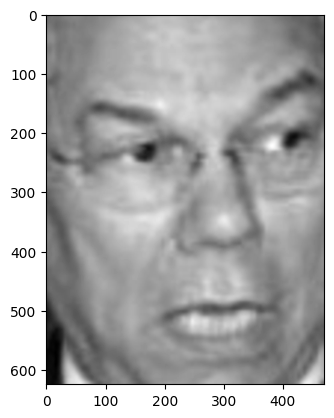

In [148]:
plt.imshow(lfw_people.images[5],cmap='gray')
plt.show()

In [149]:
np.unique(lfw_people.target)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61], dtype=int64)

In [168]:
lfw_people.target

array([61, 25,  9, ..., 14, 15, 14], dtype=int64)

In [5]:
def predict(data, labels, target, k):
    '''ранжирует k первых категорий по расстоянию и берет наиболее частую'''
    target_vector = target.flatten(order='F')

    distances = []
    for i in range(data.shape[0]):
        database_vector = data[i, :, :].flatten(order='F')
        database_label = labels[i]
        distances.append((np.linalg.norm(target_vector - database_vector), database_label))

    sorted_distances = sorted(distances, key=lambda vals: vals[0])
    k_labels = [label for (_, label) in sorted_distances[:k]]
    #print(k_labels)
    return find_majority(k_labels)

In [7]:
target = lfw_people.images[0, :, :]

In [22]:
lfw_people.images[1:, :, :].__sizeof__() * 1e-7

1.44e-05

In [30]:
predict(lfw_people.images[1:, :, :], lfw_people.target[1:], target, 1)

58

In [12]:
lfw_people.images.shape[0] / 100

30.23

In [6]:
times_naive = []
step = 302
for i in range(1, 10):
    time = %timeit -n1 -o -q predict(lfw_people.images[1:step * i, :, :], lfw_people.target[1:], target, 1)
    times_naive.append(time.average)

NameError: name 'target' is not defined

In [ ]:
storage_naive = []
for i in range(1, 10):
    storage = lfw_people.images[1:step * i, :, :].copy()
    storage_naive.append(storage.__sizeof__() * 1e-7)

In [8]:
times_naive = []
storage_naive = []
for i in range(1, 11):
    time = %timeit -n1 -o -q predict(lfw_people.images[lfw_people.target < int(i * 6), :, :], lfw_people.target[lfw_people.target < int(i * 6)], target, 1)
    times_naive.append(time.average)
    storage = lfw_people.images[lfw_people.target < int(i * 6), :, :].copy()
    storage_naive.append(storage.__sizeof__() * 1e-7)

In [ ]:
mosaic = '''
QQQ
'''
sizes = [30 * i for i in range(1, 11)]
fig, ax = plt.subplot_mosaic(mosaic=mosaic)
ax['Q'].plot(sizes, times_naive, label = "times_naive")
#ax['Q'].plot(sizes, storage_naive, label = "storage_naive")
ax['Q'].set_ylabel('seconds', fontsize=10)
ax['Q'].set_xlabel('photos', fontsize=10)
ax['Q'].legend()
fig.set_size_inches(10, 4)

plt.show()

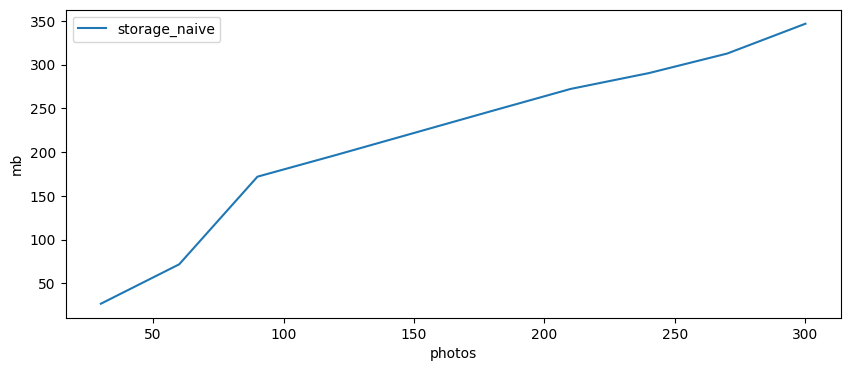

In [11]:
mosaic = '''
QQQ
'''
sizes = [30 * i for i in range(1, 11)]
fig, ax = plt.subplot_mosaic(mosaic=mosaic)
#ax['Q'].plot(sizes, times_naive, label = "times_naive")
ax['Q'].plot(sizes, storage_naive, label = "storage_naive")
ax['Q'].set_ylabel('mb', fontsize=10)
ax['Q'].set_xlabel('photos', fontsize=10)
ax['Q'].legend()
fig.set_size_inches(10, 4)

plt.show()

In [ ]:
np.unique()

In [43]:
len(np.unique(lfw_people.target))

62

In [62]:
mean_dataset = np.zeros((lfw_people.images.shape[1],lfw_people.images.shape[2] , len(np.unique(lfw_people.target))))
for i in range(lfw_people.images.shape[0]):
    mean_dataset[:, :, lfw_people.target[i]] += lfw_people.images[i]
for i in range(len(np.unique(lfw_people.target))):
    mean_dataset[:, :, i] = mean_dataset[:, :, i] / len(lfw_people.target[lfw_people.target == i])

In [159]:
mean_dataset.shape

(625, 470, 62)

In [160]:
for i in range(lfw_people.images.shape[0]):
    mean_dataset[:, :, lfw_people.target[i]] += lfw_people.images[i]

In [161]:
for i in range(len(np.unique(lfw_people.target))):
    mean_dataset[:, :, i] = mean_dataset[:, :, i] / len(lfw_people.target[lfw_people.target == i])

In [63]:
mean_dataset.__sizeof__() * 1e-7

14.5700144

In [12]:
def predict(data, labels, target, k):
    '''ранжирует k первых категорий по расстоянию и берет наиболее частую'''
    target_vector = target.flatten(order='F')

    distances = []
    for i in range(data.shape[2]):
        database_vector = data[:, :, i].flatten(order='F')
        database_label = labels[i]
        distances.append((np.linalg.norm(target_vector - database_vector), database_label))

    sorted_distances = sorted(distances, key=lambda vals: vals[0])
    k_labels = [label for (_, label) in sorted_distances[:k]]
    #print(k_labels)
    return find_majority(k_labels)

In [58]:
target = lfw_people.images[20, :, :]

In [59]:
predict(mean_dataset, np.unique(lfw_people.target), target, 1)

12

In [28]:
times_mean = []
storage_mean = []
step = 302
for k in range(1, 11):
    dataset = lfw_people.images[lfw_people.target < int(k * 6), :, :]
    targets = lfw_people.target[lfw_people.target < int(k * 6)]
    
    mean_dataset = np.zeros((dataset.shape[1],dataset.shape[2] , len(np.unique(targets))))
    for i in range(dataset.shape[0]):
        mean_dataset[:, :, targets[i]] += dataset[i]
    for i in range(len(np.unique(targets))):
        mean_dataset[:, :, i] = mean_dataset[:, :, i] / (len(targets[targets == i]))
    time = %timeit -n1 -o -q predict(mean_dataset, np.unique(targets), target, 1)
    times_mean.append(time.average)
    storage_mean.append(mean_dataset.__sizeof__() * 1e-7)

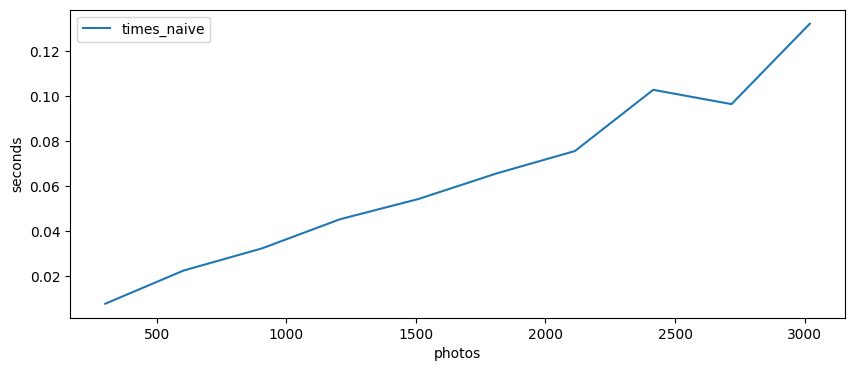

In [14]:
mosaic = '''
QQQ
'''
sizes = [302 * i for i in range(1, 11)]
fig, ax = plt.subplot_mosaic(mosaic=mosaic)
ax['Q'].plot(sizes, times_mean, label = "times_naive")
#ax['Q'].plot(sizes, storage_naive, label = "storage_naive")
ax['Q'].set_ylabel('seconds', fontsize=10)
ax['Q'].set_xlabel('photos', fontsize=10)
ax['Q'].legend()
fig.set_size_inches(10, 4)

plt.show()

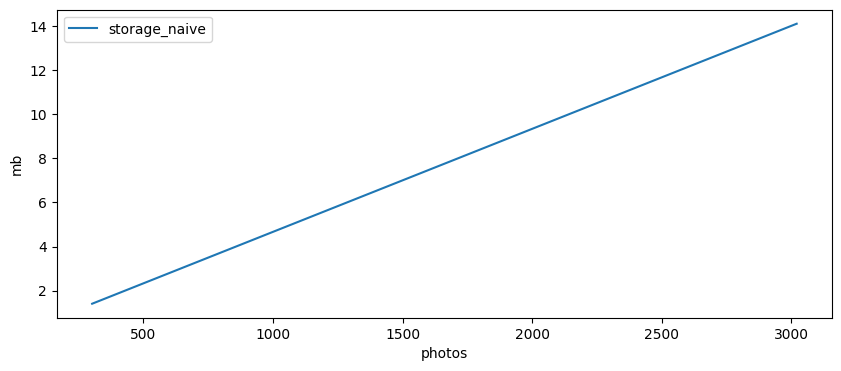

In [15]:
mosaic = '''
QQQ
'''
#storage_mean = [14.57] * 9
sizes = [302 * i for i in range(1, 11)]
fig, ax = plt.subplot_mosaic(mosaic=mosaic)
#ax['Q'].plot(sizes, times_naive, label = "times_naive")
ax['Q'].plot(sizes, storage_mean, label = "storage_naive")
ax['Q'].set_ylabel('mb', fontsize=10)
ax['Q'].set_xlabel('photos', fontsize=10)
ax['Q'].legend()
fig.set_size_inches(10, 4)

plt.show()

In [180]:
lfw_people.target

array([61, 25,  9, ..., 14, 15, 14], dtype=int64)

In [230]:
np.unique (lfw_people.target, return_counts= True )[1]

array([ 39,  35,  21,  36,  20,  77,  42,  24,  29,  21, 236,  31, 121,
        22, 530, 109,  44,  26,  30,  22,  39,  71,  20,  28,  52,  55,
        21,  42,  21,  24,  20,  53,  31,  23,  28,  60,  32,  41,  22,
        41,  48,  29,  33,  20,  22,  37,  20,  22,  30,  27,  32,  26,
        23,  52,  33,  23,  25,  33, 144,  32,  49,  24], dtype=int64)

In [32]:
times_svd = []
storage_svd = []
for k in range(1, 11):
    dataset_batch = lfw_people.images[lfw_people.target < int(k * 6), :, :]
    targets = lfw_people.target[lfw_people.target < int(k * 6)]
    
    dataset = np.zeros((lfw_people.images.shape[2] * lfw_people.images.shape[1], 20, len(np.unique(targets))))
    counter = {}
    
    for i in range(1, dataset_batch.shape[0]):
        if targets[i] not in counter:
            counter[targets[i]] = 0
        elif counter[targets[i]] > 18:
            continue
        else:
            counter[targets[i]] += 1
    
        dataset[:, counter[targets[i]], targets[i]] = dataset_batch[i].flatten(order='F')

    U_data = np.zeros(dataset.shape)
    for i in range(dataset.shape[2]):
        U, S, Vh = np.linalg.svd(dataset[:, :, i], full_matrices=False)
        U_data[:, :20, i] = U[:, :20].copy()
    m=1
    U_data = U_data[:, :10, :].copy()
    labels = np.arange(U_data.shape[2])
    target = dataset_batch[m, :, :]
    target = target.flatten(order='F')
    label = targets[m]
    time = %timeit -n1 -o -q predict_svd(U_data, labels, target, 1)
    times_svd.append(time.average)
    storage_svd.append(U_data.__sizeof__() * 1e-7)


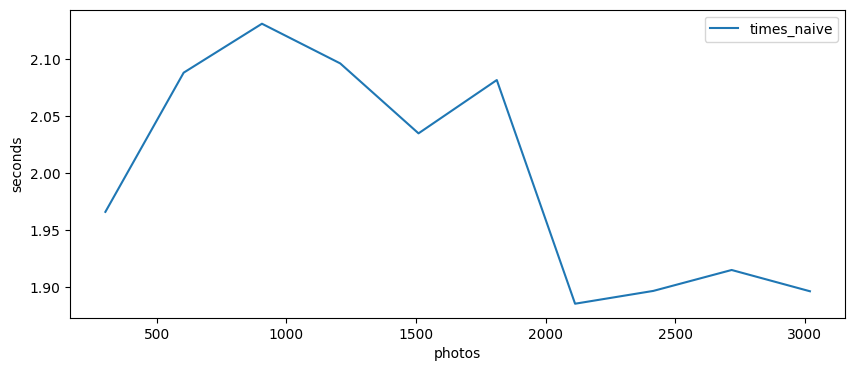

In [22]:
mosaic = '''
QQQ
'''
sizes = [302 * i for i in range(1, 11)]
fig, ax = plt.subplot_mosaic(mosaic=mosaic)
ax['Q'].plot(sizes, times_svd, label = "times_naive")
#ax['Q'].plot(sizes, storage_naive, label = "storage_naive")
ax['Q'].set_ylabel('seconds', fontsize=10)
ax['Q'].set_xlabel('photos', fontsize=10)
ax['Q'].legend()
fig.set_size_inches(10, 4)

plt.show()

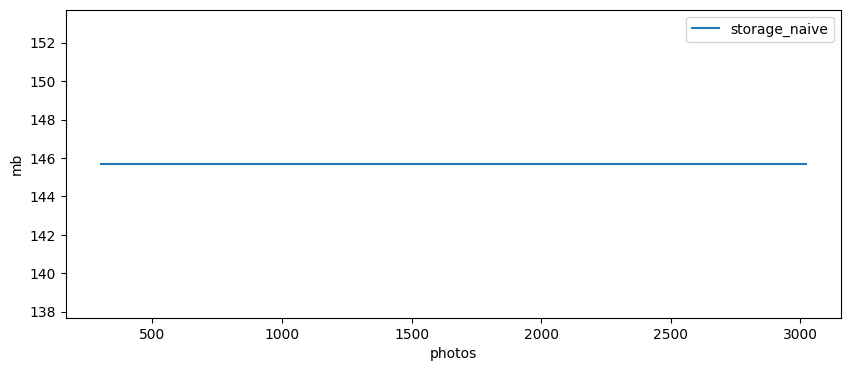

In [23]:
mosaic = '''
QQQ
'''
storage_mean = [14.57] * 9
sizes = [302 * i for i in range(1, 11)]
fig, ax = plt.subplot_mosaic(mosaic=mosaic)
#ax['Q'].plot(sizes, times_naive, label = "times_naive")
ax['Q'].plot(sizes, storage_svd, label = "storage_naive")
ax['Q'].set_ylabel('mb', fontsize=10)
ax['Q'].set_xlabel('photos', fontsize=10)
ax['Q'].legend()
fig.set_size_inches(10, 4)

plt.show()

In [4]:
dataset = np.zeros((lfw_people.images.shape[2] * lfw_people.images.shape[1], 20, len(np.unique(lfw_people.target))))
counter = {}

for i in range(1, lfw_people.images.shape[0]):
    if lfw_people.target[i] not in counter:
        counter[lfw_people.target[i]] = 0
    elif counter[lfw_people.target[i]] > 48:
        continue
    else:
        counter[lfw_people.target[i]] += 1

    dataset[:, counter[lfw_people.target[i]], lfw_people.target[i]] = lfw_people.images[i].flatten(order='F')


    

In [189]:
dataset[:, :, 1]

array([[0.37385622, 0.06405229, 0.39607844, ..., 0.12156863, 0.18169935,
        0.18039216],
       [0.37385622, 0.06405229, 0.39607844, ..., 0.12156863, 0.18169935,
        0.18039216],
       [0.36993465, 0.06013072, 0.39607844, ..., 0.12156863, 0.17777778,
        0.18039216],
       ...,
       [0.26013073, 0.9450981 , 0.59738564, ..., 0.83137256, 0.09150327,
        0.13594772],
       [0.26013073, 0.94248366, 0.59738564, ..., 0.82745099, 0.09150327,
        0.13594772],
       [0.26013073, 0.94248366, 0.59738564, ..., 0.82745099, 0.09281046,
        0.13594772]])

In [20]:
U_data = np.zeros(dataset.shape)
for i in range(dataset.shape[2]):
    U, S, Vh = np.linalg.svd(dataset[:, :, i], full_matrices=False)
    U_data[:, :20, i] = U[:, :20]

In [221]:
U_data = U_data[:, :10, :]

In [16]:
def predict_svd(data, labels, target, k):
    '''
    ранжирует k первых категорий по расстоянию и берет наиболее частую
    '''

    target_vector = target

    norm_target = np.linalg.norm(target_vector)

    distances = []
    for i in range(data.shape[2]):
        database_matrix = data[:, :, i]
        database_label = labels[i]
        distances.append((np.linalg.norm((target_vector - database_matrix @ (database_matrix.T @ target_vector)) / norm_target), database_label))

    sorted_distances = sorted(distances, key=lambda vals: vals[0])
    k_labels = [label for (_, label) in sorted_distances[:k]]
    #print(k_labels)
    return find_majority(k_labels)

In [11]:
m = 11
labels = np.arange(U_data.shape[2])
target = lfw_people.images[m, :, :]
target = target.flatten(order='F')
lfw_people.target[m]

14

In [12]:
indices = np.arange(lfw_people.images.shape[0])
np.random.shuffle(indices)

In [223]:
counter = 0
for k in range(100):
    i = indices[k]
    target = lfw_people.images[i, :, :].flatten(order='F')
    label = lfw_people.target[i]
    result = predict_svd(U_data, labels, target, 1)
    if result == label:
        counter += 1
print(counter / 100)

0.65


In [224]:
U_data.__sizeof__() * 1e-7

1.44e-05

In [225]:
U_data = U_data[:, :7, :]

In [226]:
counter = 0
for k in range(100):
    i = indices[k]
    target = lfw_people.images[i, :, :].flatten(order='F')
    label = lfw_people.target[i]
    result = predict_svd(U_data, labels, target, 1)
    if result == label:
        counter += 1
print(counter / 100)

0.65


In [227]:
U_data.__sizeof__() * 1e-7

1.44e-05

большинство данных в U

In [ ]:
dataset = np.zeros((lfw_people.images.shape[2] * lfw_people.images.shape[1], 50, len(np.unique(lfw_people.target))))
counter = {}

for i in range(1, lfw_people.images.shape[0]):
    if lfw_people.target[i] not in counter:
        counter[lfw_people.target[i]] = 0
    elif counter[lfw_people.target[i]] > 48:
        continue
    else:
        counter[lfw_people.target[i]] += 1

    dataset[:, counter[lfw_people.target[i]], lfw_people.target[i]] = lfw_people.images[i].flatten(order='F')


In [ ]:
U_data = np.zeros(dataset.shape)
for i in range(dataset.shape[2]):
    U, S, Vh = np.linalg.svd(dataset[:, :, i], full_matrices=False)
    U_data[:, :20, i] = U[:, :20]

In [21]:
U_data = U_data[:, :20, :]

In [23]:
counter = 0
for k in range(100):
    i = indices[k]
    target = lfw_people.images[i, :, :].flatten(order='F')
    label = lfw_people.target[i]
    result = predict_svd(U_data, labels, target, 1)
    if result == label:
        counter += 1
print(counter / 100)

0.85


In [22]:
U_data.__sizeof__() * 1e-7

1.44e-05

In [14]:
U_data = U_data[:, :10, :]

In [16]:
counter = 0
for k in range(100):
    i = indices[k]
    target = lfw_people.images[i, :, :].flatten(order='F')
    label = lfw_people.target[i]
    result = predict_svd(U_data, labels, target, 1)
    if result == label:
        counter += 1
print(counter / 100)

0.82


In [15]:
U_data.__sizeof__() * 1e-7

1.44e-05

In [17]:
U_data = U_data[:, :7, :]

In [18]:
counter = 0
for k in range(100):
    i = indices[k]
    target = lfw_people.images[i, :, :].flatten(order='F')
    label = lfw_people.target[i]
    result = predict_svd(U_data, labels, target, 1)
    if result == label:
        counter += 1
print(counter / 100)

0.75


In [19]:
U_data.__sizeof__() * 1e-7

1.44e-05

In [27]:
len(times_naive)

10

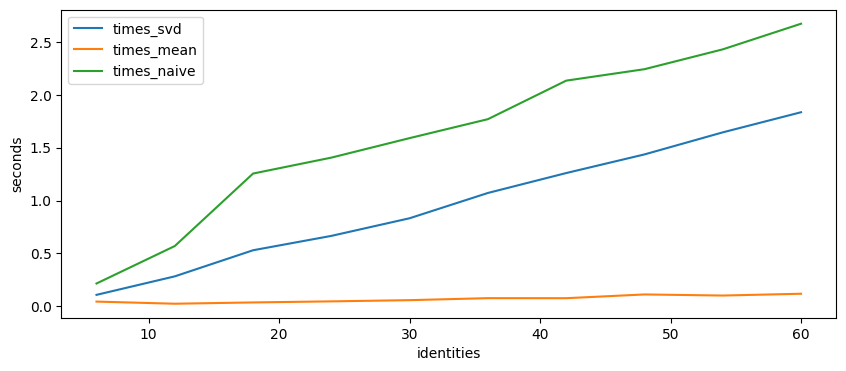

In [33]:
mosaic = '''
QQQ
'''
times_naive
times_mean
sizes = [6 * i for i in range(1, 11)]
fig, ax = plt.subplot_mosaic(mosaic=mosaic)
ax['Q'].plot(sizes, times_svd, label = "times_svd")
ax['Q'].plot(sizes, times_mean, label = "times_mean")
ax['Q'].plot(sizes, times_naive, label = "times_naive")

ax['Q'].set_ylabel('seconds', fontsize=10)
ax['Q'].set_xlabel('identities', fontsize=10)
ax['Q'].legend()
fig.set_size_inches(10, 4)

plt.show()

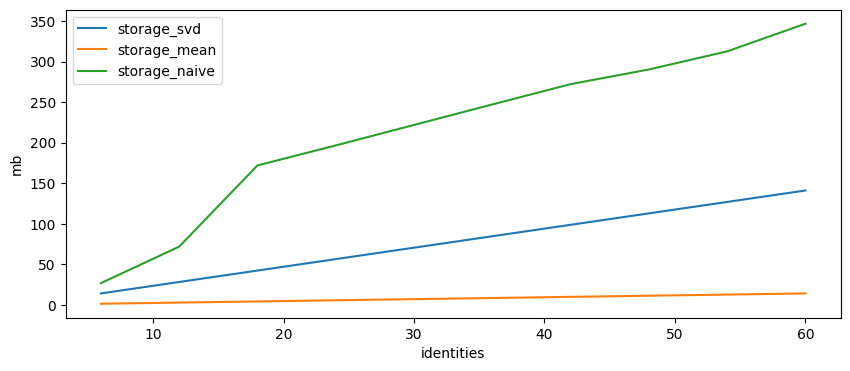

In [34]:
mosaic = '''
QQQ
'''
storage_mean
storage_naive
sizes = [6 * i for i in range(1, 11)]
fig, ax = plt.subplot_mosaic(mosaic=mosaic)
#ax['Q'].plot(sizes, times_naive, label = "times_naive")
ax['Q'].plot(sizes, storage_svd, label = "storage_svd")
ax['Q'].plot(sizes, storage_mean, label = "storage_mean")
ax['Q'].plot(sizes, storage_naive, label = "storage_naive")
ax['Q'].set_ylabel('mb', fontsize=10)
ax['Q'].set_xlabel('identities', fontsize=10)
ax['Q'].legend()
fig.set_size_inches(10, 4)

plt.show()

In [ ]:
,,